In [1]:
"""
06_rmt_python_reimplementation.ipynb
=====================================
Random Matrix Theory (RMT) for Neural Network Weight Analysis.

Reimplements core RMT tools in pure Python/NumPy following the
RMT-TheoryAndPractice repo (https://github.com/RMT-TheoryAndPractice/RMT).

Contents:
  1. Marchenko-Pastur law – theoretical density & fit to empirical ESD
  2. Tracy-Widom statistics – largest eigenvalue test for spiked models
  3. Spectral bulk + outlier detection
  4. Weight matrix conditioning (condition number, effective rank)
  5. Demo on Merged zoo.csv – spectral analysis of CNN layer weight matrices

CNN architecture (from AE.py):
  Conv2d(1,8,5)  → Conv2d(8,6,5) → Conv2d(6,4,2) → Linear(36,20) → Linear(20,10)
  Flattened: weight 0..2453  (2454 weights),  bias 2454..2463  (10 biases)
"""

import sys, os, ast, warnings
from pathlib import Path
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ks_2samp
from scipy.linalg import svdvals
from scipy.optimize import minimize_scalar
from sklearn.decomposition import PCA

ROOT = Path("..").resolve()
DATA_DIR = ROOT / "data"
FIG_DIR  = Path("figures/06_rmt")
FIG_DIR.mkdir(parents=True, exist_ok=True)
MERGED_ZOO = DATA_DIR / "Merged zoo.csv"

ACTIVATION_COLS = ["gelu", "relu", "silu", "tanh", "sigmoid", "leakyrelu"]
DIGIT_COLS = [str(i) for i in range(10)]

print("=== 06 – Random Matrix Theory for Weight Analysis ===")
print(f"Data file : {MERGED_ZOO}  (exists={MERGED_ZOO.exists()})")
print(f"Figure dir: {FIG_DIR.resolve()}")

=== 06 – Random Matrix Theory for Weight Analysis ===
Data file : /home/aymen/Documents/GitHub/Federated-Continual-learning-/New/data/Merged zoo.csv  (exists=True)
Figure dir: /home/aymen/Documents/GitHub/Federated-Continual-learning-/New/notebooks_sandbox/figures/06_rmt


In [2]:
# Cell 2 – Load data & reconstruct weight matrices per CNN layer

print("Loading Merged zoo.csv …")
df = pd.read_csv(MERGED_ZOO)

weight_cols = [c for c in df.columns if c.startswith("weight ")]
bias_cols   = [c for c in df.columns if c.startswith("bias ")]
param_cols  = weight_cols + bias_cols

for c in ACTIVATION_COLS + DIGIT_COLS:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce").fillna(0).astype(int)
df["Accuracy"] = pd.to_numeric(df["Accuracy"], errors="coerce")
df["epoch"]    = pd.to_numeric(df["epoch"], errors="coerce").astype(int)

def _get_activation(row):
    for a in ACTIVATION_COLS:
        if row.get(a, 0) == 1:
            return a
    return "unknown"
df["activation"] = df.apply(_get_activation, axis=1)

def parse_label(s):
    try:
        return tuple(sorted(ast.literal_eval(s)))
    except Exception:
        return None
df["label_tuple"] = df["label"].apply(parse_label)

# CNN layer boundaries (from AE.py CNN class):
# Conv2d(1,8,5)  : 8 filters × (1×5×5) = 200 weights  → indices 0..199
# Conv2d(8,6,5)  : 6 filters × (8×5×5) = 1200 weights → indices 200..1399
# Conv2d(6,4,2)  : 4 filters × (6×2×2) = 96 weights   → indices 1400..1495
# Linear(36,20)  : 20 × 36 = 720 weights               → indices 1496..2215
# Linear(20,10)  : 10 × 20 = 200 weights                → indices 2216..2415
# (remaining up to 2453 may be from biases interleaved; we use the main blocks)

LAYER_SPECS = {
    "conv1": {"start": 0,    "end": 200,  "shape": (8, 25)},     # 8 filters, 1*5*5=25
    "conv2": {"start": 200,  "end": 1400, "shape": (6, 200)},    # 6 filters, 8*5*5=200
    "conv3": {"start": 1400, "end": 1496, "shape": (4, 24)},     # 4 filters, 6*2*2=24
    "fc1":   {"start": 1496, "end": 2216, "shape": (20, 36)},    # 20×36
    "fc2":   {"start": 2216, "end": 2416, "shape": (10, 20)},    # 10×20
}

def extract_layer_matrix(row_weights, spec):
    """Extract a single layer's weight matrix from a flat weight vector."""
    flat = row_weights[spec["start"]:spec["end"]]
    if len(flat) != spec["shape"][0] * spec["shape"][1]:
        return flat.reshape(-1, 1)  # fallback
    return flat.reshape(spec["shape"])

print(f"  Rows: {len(df):,}")
print(f"  Layer specs:")
for name, spec in LAYER_SPECS.items():
    r, c = spec["shape"]
    print(f"    {name:6s}: indices [{spec['start']}..{spec['end']}), "
          f"matrix {r}×{c}, γ = {c/r:.2f}")
print("Done.")

Loading Merged zoo.csv …
  Rows: 36,468
  Layer specs:
    conv1 : indices [0..200), matrix 8×25, γ = 3.12
    conv2 : indices [200..1400), matrix 6×200, γ = 33.33
    conv3 : indices [1400..1496), matrix 4×24, γ = 6.00
    fc1   : indices [1496..2216), matrix 20×36, γ = 1.80
    fc2   : indices [2216..2416), matrix 10×20, γ = 2.00
Done.


In [3]:
# Cell 3 – RMT Core: Marchenko-Pastur Law

def marchenko_pastur_pdf(x, gamma, sigma2=1.0):
    """
    Marchenko-Pastur density for ratio γ = p/n and variance σ².
    Supported on [λ_-, λ_+] where λ± = σ²(1 ± √γ)².
    """
    lam_minus = sigma2 * (1 - np.sqrt(gamma))**2
    lam_plus  = sigma2 * (1 + np.sqrt(gamma))**2
    
    density = np.zeros_like(x, dtype=float)
    mask = (x > lam_minus) & (x < lam_plus)
    density[mask] = (1.0 / (2 * np.pi * sigma2 * gamma * x[mask])) * \
                    np.sqrt((lam_plus - x[mask]) * (x[mask] - lam_minus))
    return density

def marchenko_pastur_bounds(gamma, sigma2=1.0):
    """Return (λ_-, λ_+) for the MP distribution."""
    lam_minus = sigma2 * (1 - np.sqrt(gamma))**2
    lam_plus  = sigma2 * (1 + np.sqrt(gamma))**2
    return lam_minus, lam_plus

def fit_mp_sigma(eigenvalues, gamma):
    """
    Fit σ² so that the MP bulk best matches the empirical ESD.
    Uses KS-statistic minimisation.
    """
    def neg_log_lik(log_sigma2):
        sigma2 = np.exp(log_sigma2)
        lm, lp = marchenko_pastur_bounds(gamma, sigma2)
        # Fraction of eigenvalues inside the bulk
        inside = np.mean((eigenvalues >= lm) & (eigenvalues <= lp))
        # We want to maximise inside (minimise -inside)
        return -inside
    
    res = minimize_scalar(neg_log_lik, bounds=(-6, 6), method="bounded")
    return np.exp(res.x)

# ── Tracy-Widom approximation ──
# TW1 distribution: approximate CDF via shifted-Gaussian fit
# (exact TW requires special function tables; this is standard practice)

def tracy_widom_test(eigenvalues, gamma, sigma2=1.0, alpha=0.05):
    """
    Test whether the largest eigenvalue is a significant outlier
    using the Tracy-Widom (TW1) centering/scaling.
    
    Under H0 (no spike): (λ_max - μ_n) / σ_n → TW1
    where μ_n = σ²(1+√γ)²,  σ_n = σ²(1+√γ)(1/√n + 1/√p)^{1/3} · n^{-2/3}
    
    We use the BBP threshold: spike detectable if λ > σ²(1+√γ)².
    """
    n = len(eigenvalues)
    p = int(round(gamma * n))
    
    lam_plus = sigma2 * (1 + np.sqrt(gamma))**2
    lam_max  = eigenvalues.max()
    
    # Tracy-Widom scaling
    mu_n  = lam_plus
    sig_n = lam_plus * (1/np.sqrt(n) + 1/np.sqrt(max(p, 1)))**(1/3)
    
    tw_stat = (lam_max - mu_n) / max(sig_n, 1e-12)
    
    # Approximate TW1 critical values (from tables):
    # α=0.05 → c ≈ 0.9794,  α=0.01 → c ≈ 2.0234
    tw_critical = {0.05: 0.9794, 0.01: 2.0234, 0.10: 0.4500}
    crit = tw_critical.get(alpha, 0.9794)
    
    is_spike = tw_stat > crit
    
    return {
        "lam_max": float(lam_max),
        "lam_plus": float(lam_plus),
        "tw_statistic": float(tw_stat),
        "tw_critical": float(crit),
        "is_spike": bool(is_spike),
        "alpha": alpha,
    }

print("RMT core functions defined: marchenko_pastur_pdf, fit_mp_sigma, tracy_widom_test.")

RMT core functions defined: marchenko_pastur_pdf, fit_mp_sigma, tracy_widom_test.


In [4]:
# Cell 4 – RMT Core: Spectral analysis helpers

def empirical_spectral_density(matrix, method="covariance"):
    """
    Compute eigenvalues of the sample covariance matrix W W^T / n.
    matrix: (p, n) or (n, p) – we ensure p ≤ n by transposing if needed.
    Returns sorted eigenvalues, gamma = p/n, the matrix used.
    """
    M = np.array(matrix, dtype=np.float64)
    p, n = M.shape
    if p > n:
        M = M.T
        p, n = M.shape
    gamma = p / n
    
    # Sample covariance
    cov = M @ M.T / n
    eigvals = np.linalg.eigvalsh(cov)
    eigvals = np.sort(eigvals)
    
    return eigvals, gamma, M

def spectral_analysis(matrix, layer_name="", sigma2=None, plot=True, save_path=None):
    """
    Full spectral analysis of a weight matrix:
      - ESD histogram vs MP fit
      - Outlier detection via Tracy-Widom
      - Condition number, effective rank
    """
    eigvals, gamma, M = empirical_spectral_density(matrix)
    p, n = M.shape
    
    # Fit σ² if not provided
    if sigma2 is None:
        sigma2 = fit_mp_sigma(eigvals, gamma)
    
    lam_minus, lam_plus = marchenko_pastur_bounds(gamma, sigma2)
    
    # Tracy-Widom test
    tw = tracy_widom_test(eigvals, gamma, sigma2)
    
    # Outliers: eigenvalues beyond λ_+
    outliers = eigvals[eigvals > lam_plus * 1.01]
    bulk     = eigvals[(eigvals >= lam_minus * 0.99) & (eigvals <= lam_plus * 1.01)]
    
    # Condition number & effective rank
    sv = svdvals(M)
    cond_number = sv[0] / max(sv[-1], 1e-12)
    eff_rank = (sv.sum()**2) / (sv**2).sum()  # Roy's effective rank
    
    stats = {
        "layer": layer_name,
        "shape": f"{p}×{n}",
        "gamma": gamma,
        "sigma2_fit": sigma2,
        "lam_minus": lam_minus,
        "lam_plus": lam_plus,
        "n_outliers": len(outliers),
        "n_bulk": len(bulk),
        "tw_stat": tw["tw_statistic"],
        "tw_is_spike": tw["is_spike"],
        "lam_max": tw["lam_max"],
        "condition_number": cond_number,
        "effective_rank": eff_rank,
    }
    
    if plot:
        fig, axes = plt.subplots(1, 2, figsize=(14, 5))
        
        # Left: ESD vs MP
        ax = axes[0]
        ax.hist(eigvals, bins=50, density=True, alpha=0.6, color="steelblue",
                edgecolor="white", label="Empirical ESD")
        x_mp = np.linspace(max(0, lam_minus * 0.5), lam_plus * 1.5, 500)
        y_mp = marchenko_pastur_pdf(x_mp, gamma, sigma2)
        ax.plot(x_mp, y_mp, "r-", lw=2, label=f"MP (γ={gamma:.2f}, σ²={sigma2:.3f})")
        ax.axvline(lam_plus, color="orange", ls="--", lw=1.2, label=f"λ+ = {lam_plus:.3f}")
        if len(outliers) > 0:
            ax.scatter(outliers, np.zeros_like(outliers), c="red", s=60, zorder=5,
                       marker="^", label=f"{len(outliers)} outlier(s)")
        ax.set_xlabel("Eigenvalue")
        ax.set_ylabel("Density")
        ax.set_title(f"{layer_name} – ESD vs Marchenko-Pastur", fontweight="bold")
        ax.legend(fontsize=8)
        ax.grid(True, alpha=0.2)
        
        # Right: singular value spectrum
        ax = axes[1]
        ax.semilogy(range(1, len(sv) + 1), sv, "o-", markersize=3, lw=1)
        ax.set_xlabel("Singular value index")
        ax.set_ylabel("Singular value (log)")
        ax.set_title(f"{layer_name} – Singular Values\n"
                      f"κ={cond_number:.1f}, eff_rank={eff_rank:.1f}",
                      fontweight="bold")
        ax.grid(True, alpha=0.3)
        
        plt.tight_layout()
        if save_path:
            fig.savefig(save_path, dpi=200, bbox_inches="tight")
            print(f"  Saved: {save_path}")
        plt.show()
    
    return stats

print("Spectral analysis functions defined.")

Spectral analysis functions defined.


=== Spectral Analysis of Individual CNN Models ===

Analysing 3 sample models …

Model idx=18234  epoch=11  acc=98.09  label=[0, 1]
  Saved: figures/06_rmt/individual_ep11_conv1.png


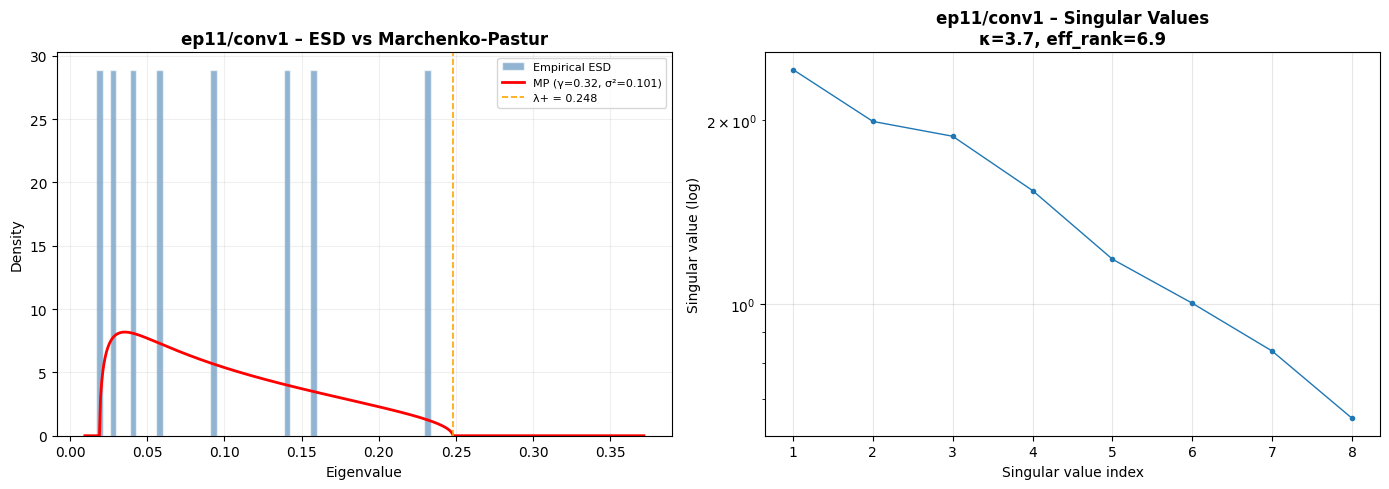

  Saved: figures/06_rmt/individual_ep11_conv2.png


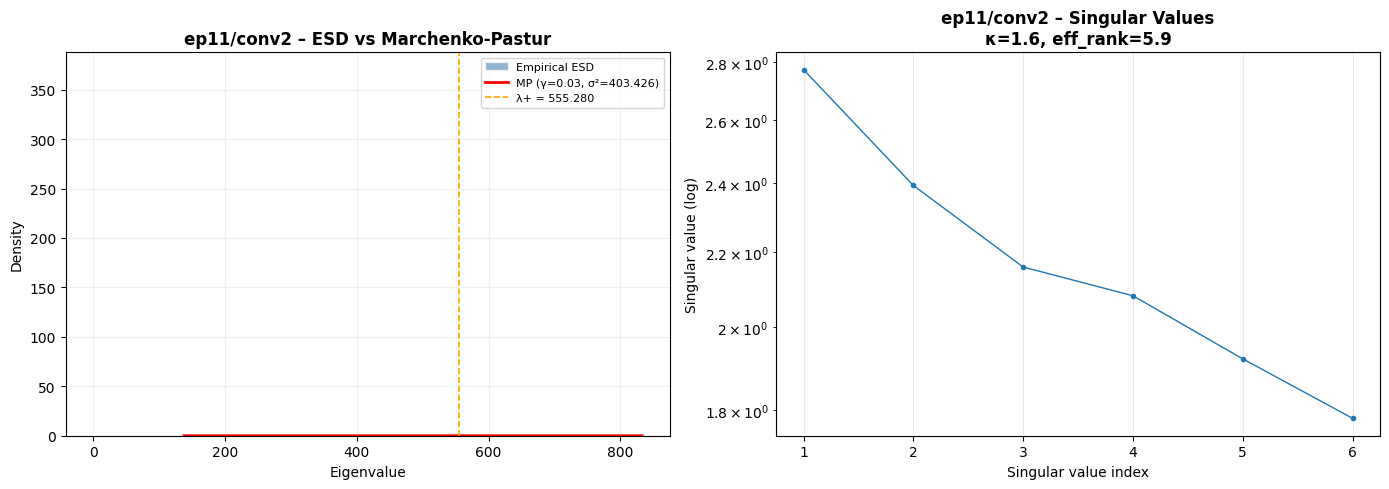

  Saved: figures/06_rmt/individual_ep11_conv3.png


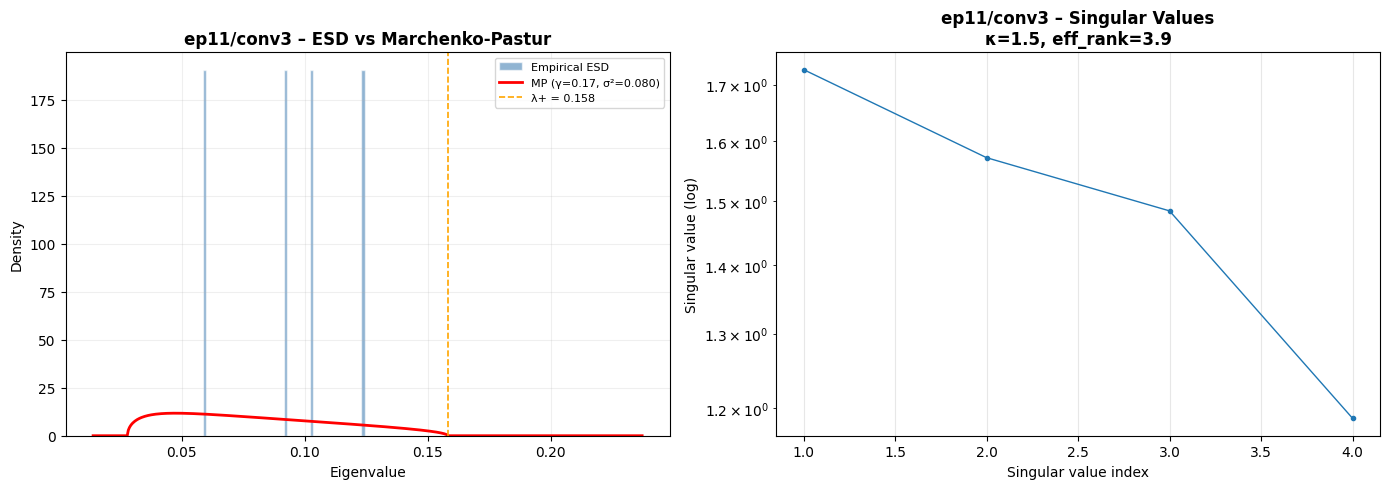

  Saved: figures/06_rmt/individual_ep11_fc1.png


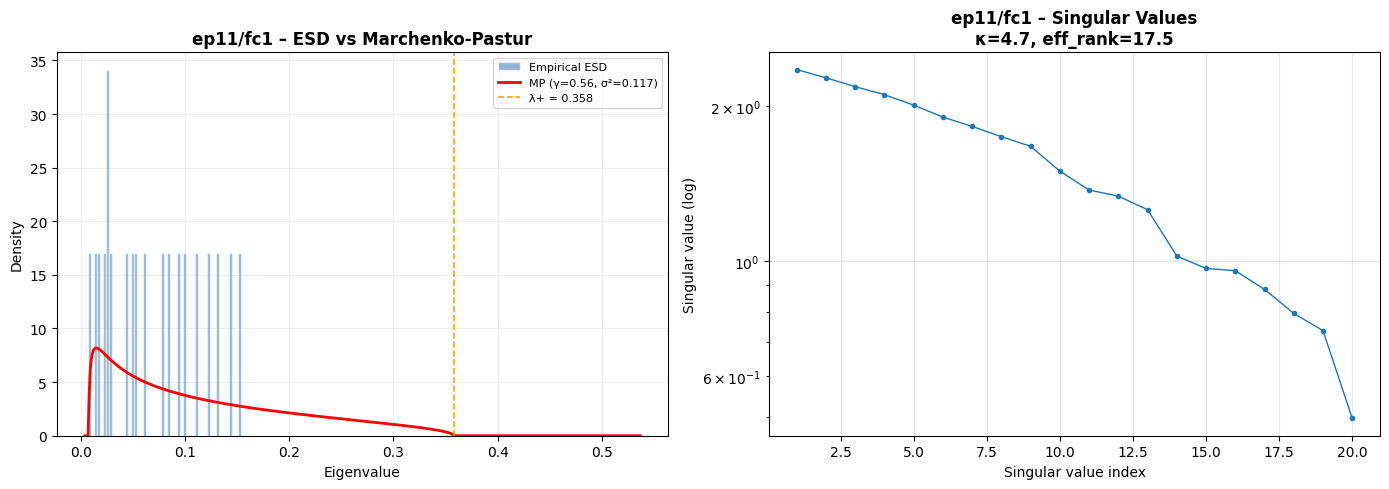

  Saved: figures/06_rmt/individual_ep11_fc2.png


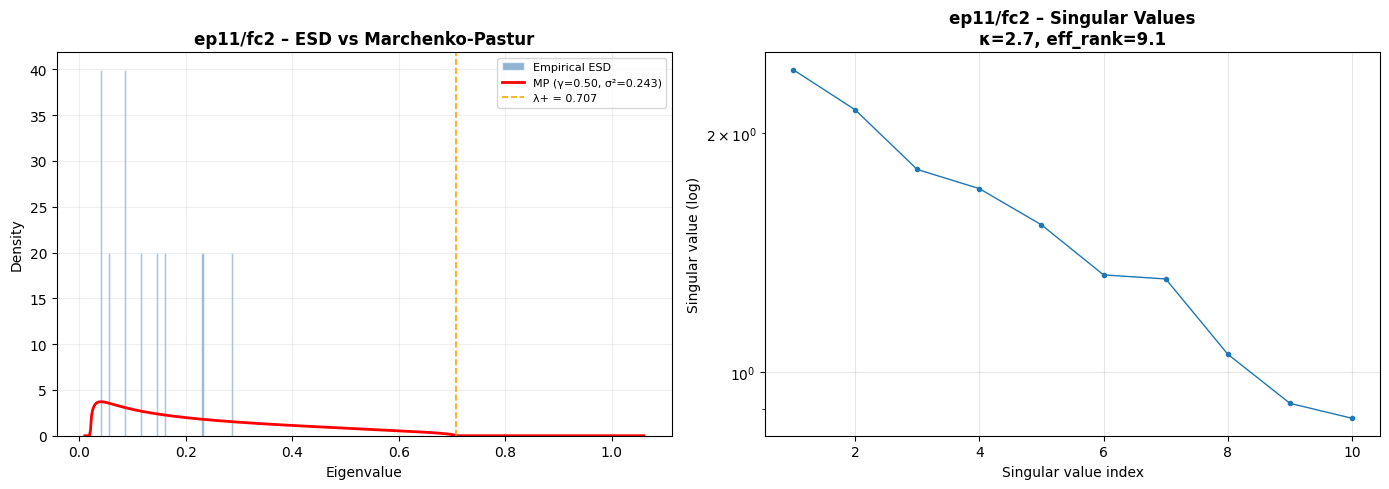


Model idx=24312  epoch=26  acc=98.69  label=[0, 1]
  Saved: figures/06_rmt/individual_ep26_conv1.png


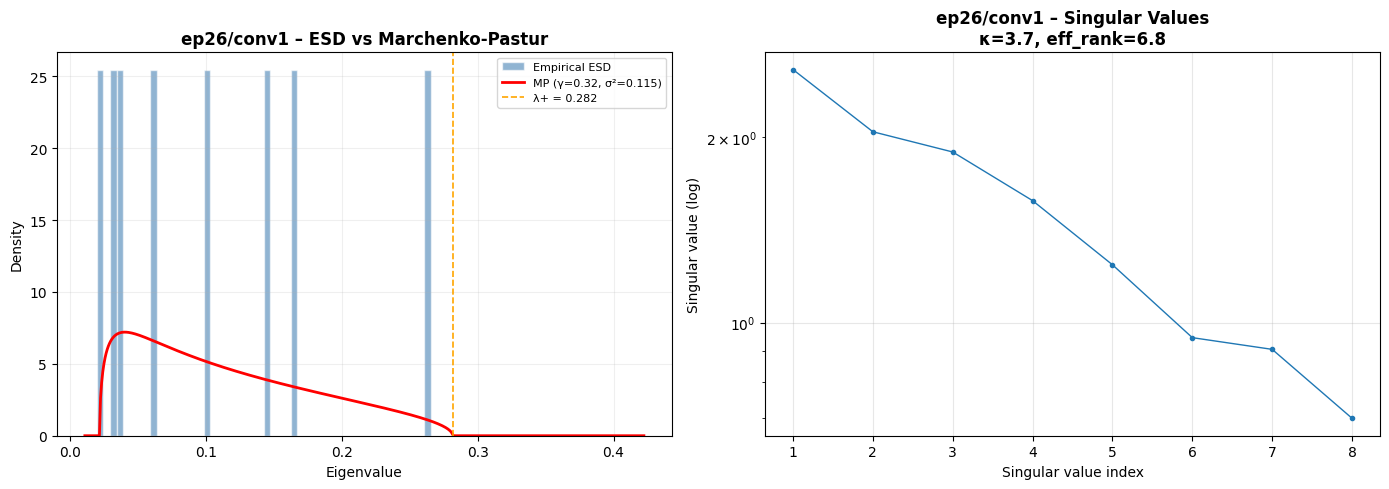

  Saved: figures/06_rmt/individual_ep26_conv2.png


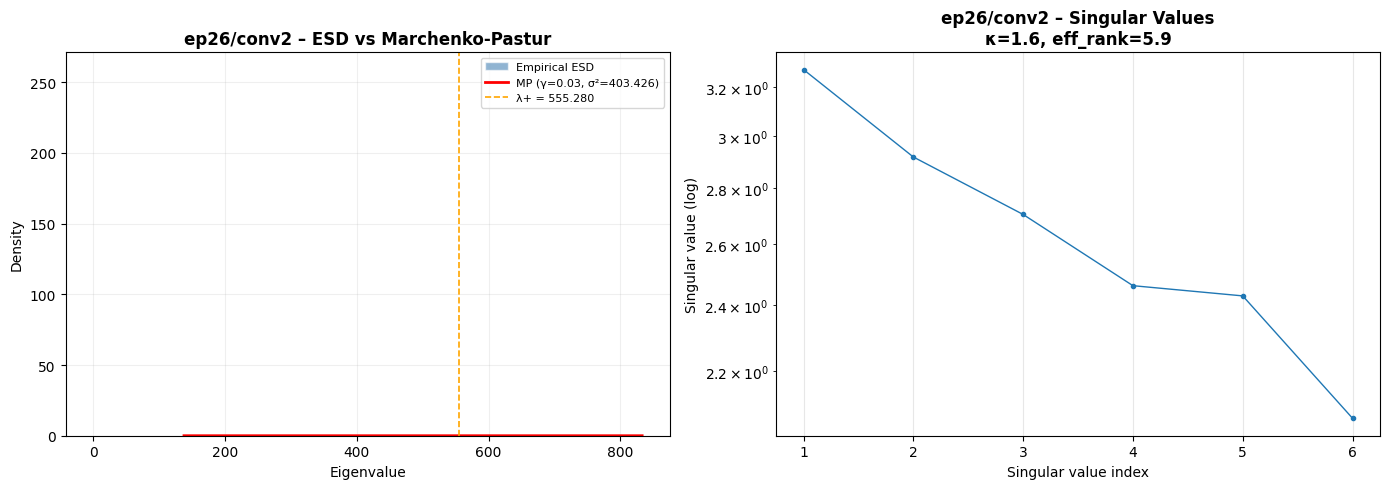

  Saved: figures/06_rmt/individual_ep26_conv3.png


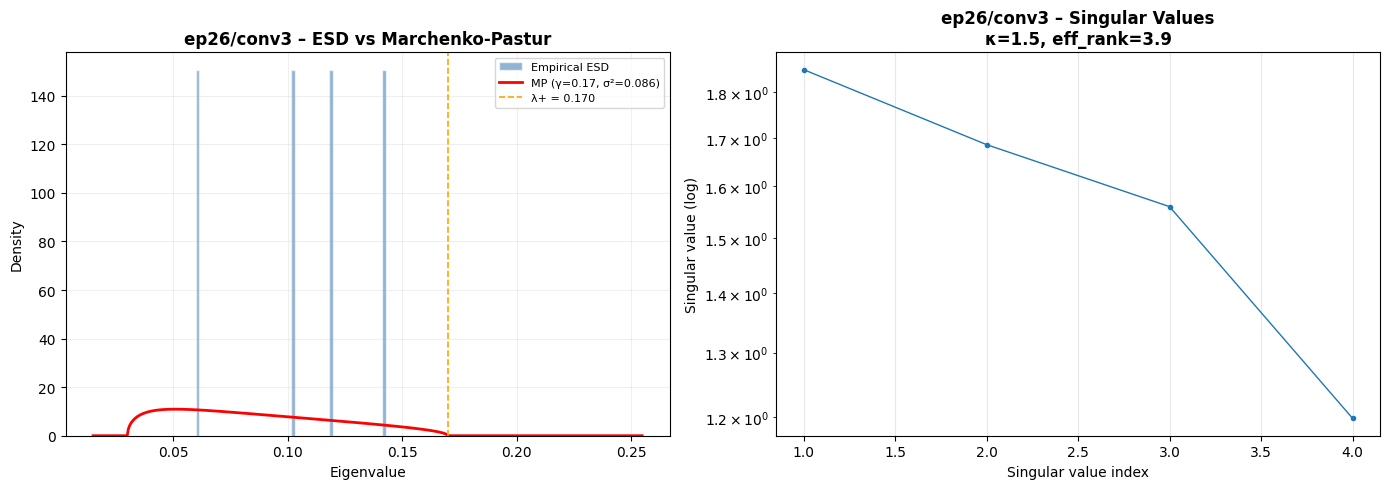

  Saved: figures/06_rmt/individual_ep26_fc1.png


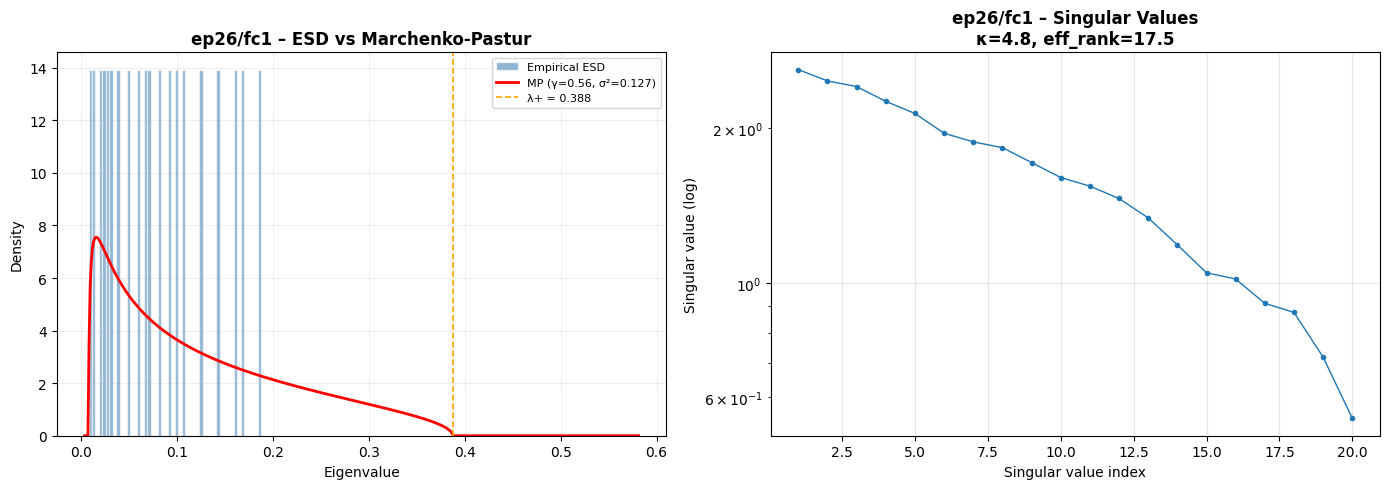

  Saved: figures/06_rmt/individual_ep26_fc2.png


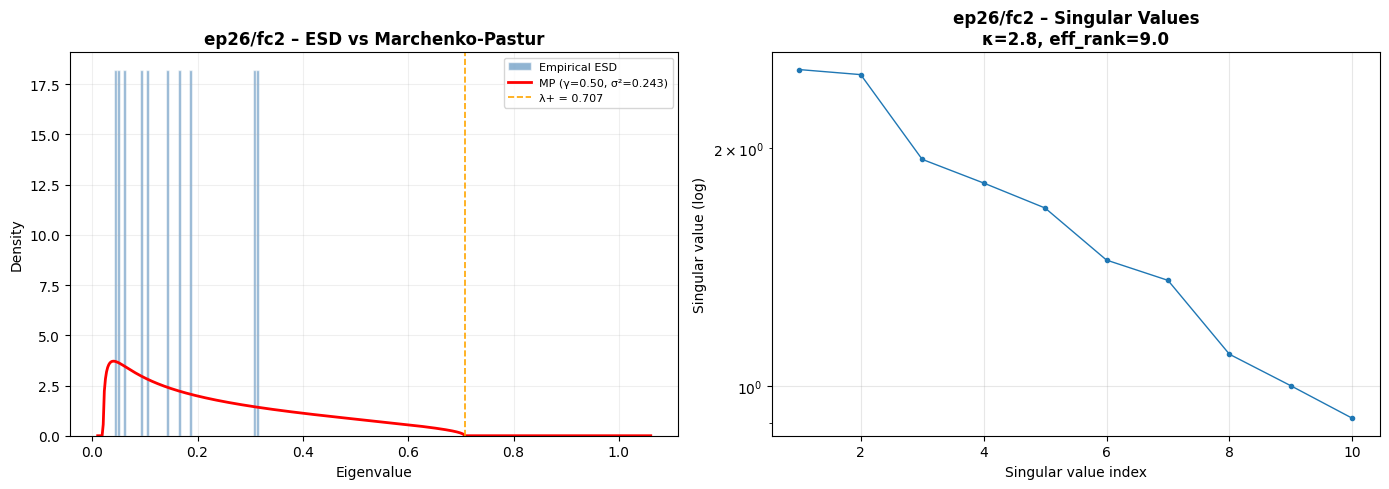


Model idx=0  epoch=36  acc=98.64  label=[0, 1]
  Saved: figures/06_rmt/individual_ep36_conv1.png


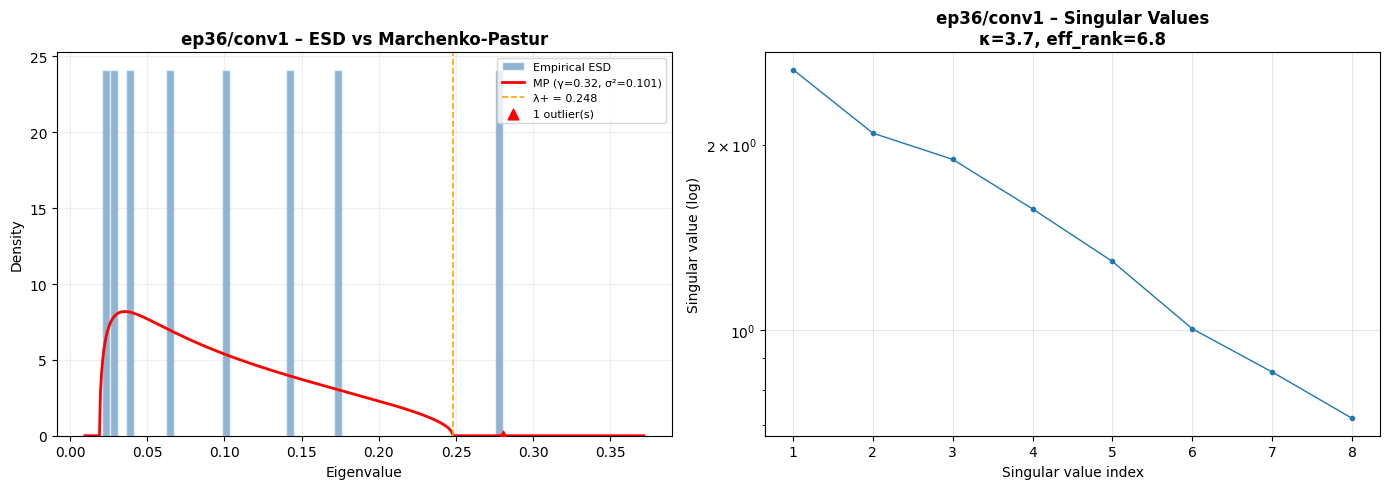

  Saved: figures/06_rmt/individual_ep36_conv2.png


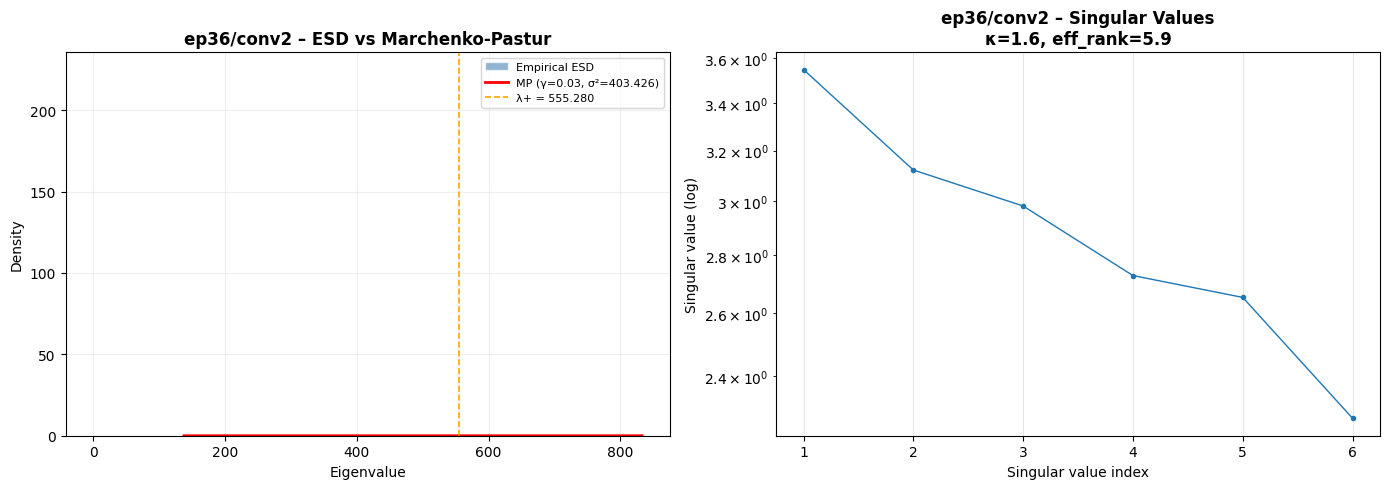

  Saved: figures/06_rmt/individual_ep36_conv3.png


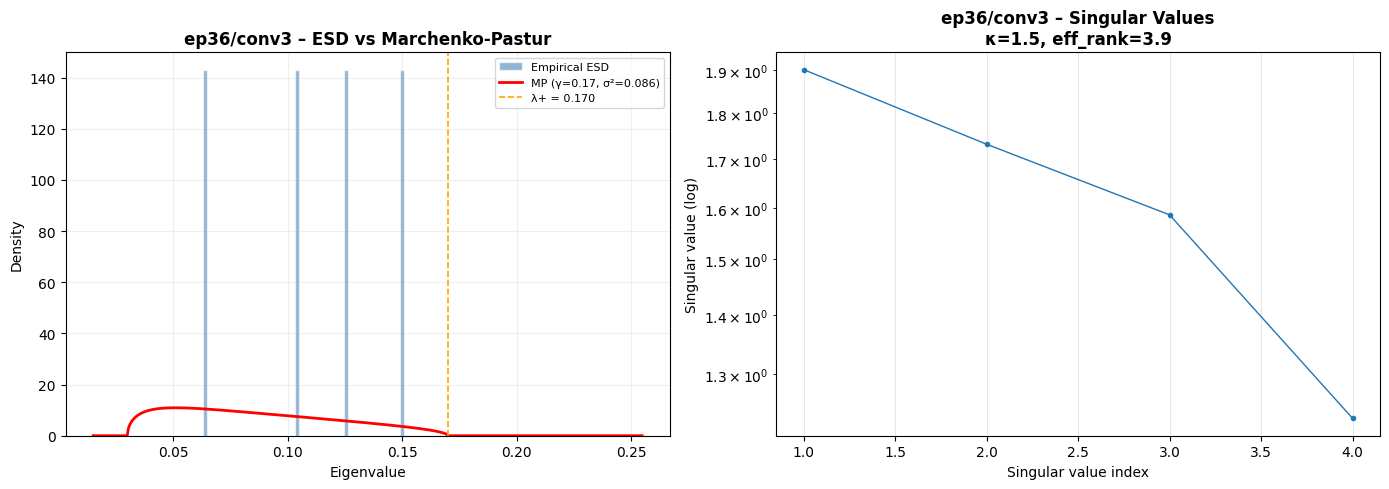

  Saved: figures/06_rmt/individual_ep36_fc1.png


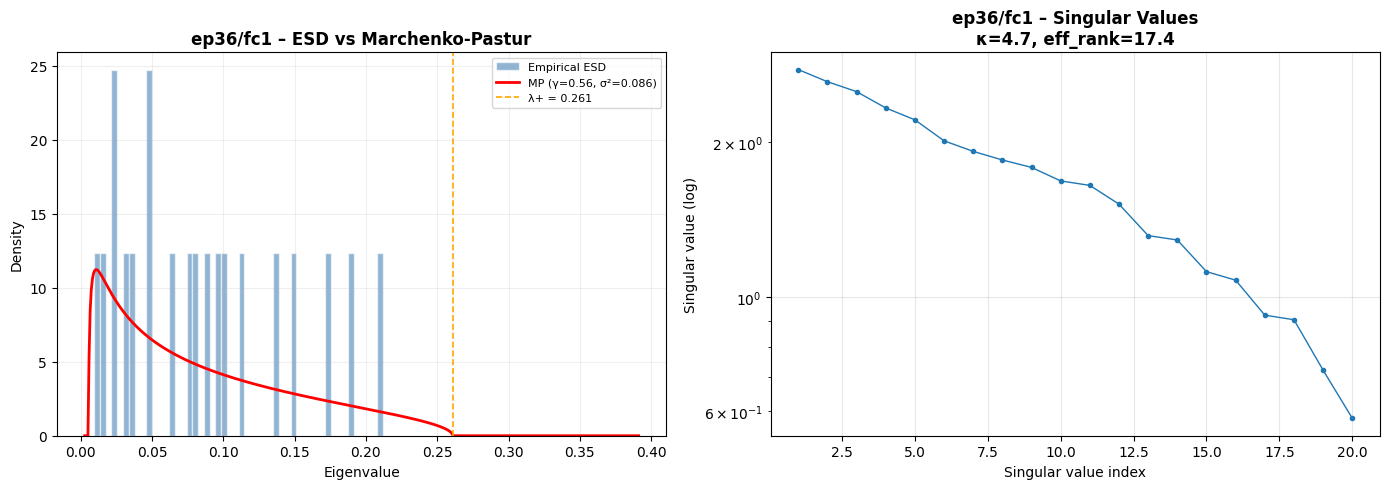

  Saved: figures/06_rmt/individual_ep36_fc2.png


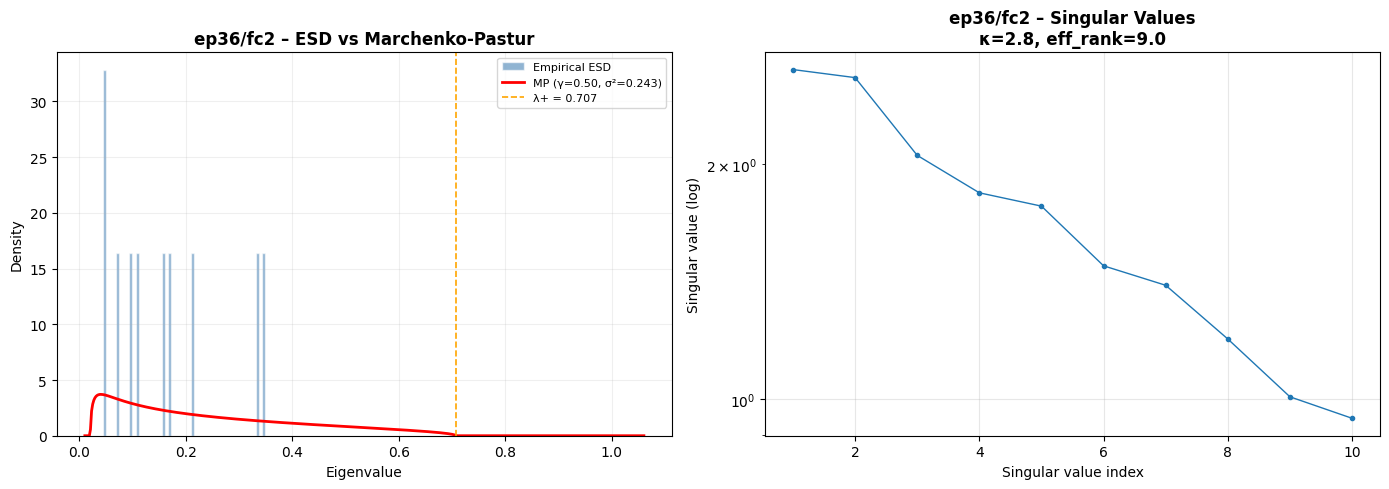


Individual model spectral stats:
     layer  epoch    gamma  sigma2_fit  n_outliers  tw_is_spike  condition_number  effective_rank
ep11/conv1     11 0.320000    0.101086           0        False          3.714664        6.875930
ep11/conv2     11 0.030000  403.426191           0        False          1.555615        5.870542
ep11/conv3     11 0.166667    0.079726           0        False          1.455776        3.931569
  ep11/fc1     11 0.555556    0.117431           0        False          4.729583       17.522274
  ep11/fc2     11 0.500000    0.242585           0        False          2.746727        9.058416
ep26/conv1     26 0.320000    0.114856           0        False          3.686197        6.843106
ep26/conv2     26 0.030000  403.426191           0        False          1.584202        5.875425
ep26/conv3     26 0.166667    0.085626           0        False          1.546055        3.908699
  ep26/fc1     26 0.555556    0.127208           0        False          4.772210   

In [5]:
# Cell 5 – Demo: spectral analysis of individual CNN models from the zoo
# Pick a few models and analyse each layer's weight matrix.

print("=== Spectral Analysis of Individual CNN Models ===\n")

# Select a few diverse models
sample_indices = []
for ep in [11, 26, 36]:
    df_ep = df[df["epoch"] == ep]
    if len(df_ep) > 0:
        sample_indices.append(df_ep.index[0])

print(f"Analysing {len(sample_indices)} sample models …")

individual_stats = []

for idx in sample_indices:
    row = df.loc[idx]
    w_flat = row[weight_cols].values.astype(np.float64)
    ep = int(row["epoch"])
    acc = float(row["Accuracy"])
    label_str = str(row["label"])
    
    print(f"\n{'='*60}")
    print(f"Model idx={idx}  epoch={ep}  acc={acc:.2f}  label={label_str}")
    print(f"{'='*60}")
    
    for layer_name, spec in LAYER_SPECS.items():
        W = extract_layer_matrix(w_flat, spec)
        stats = spectral_analysis(
            W, layer_name=f"ep{ep}/{layer_name}",
            save_path=FIG_DIR / f"individual_ep{ep}_{layer_name}.png"
        )
        stats["epoch"] = ep
        stats["accuracy"] = acc
        individual_stats.append(stats)

ind_df = pd.DataFrame(individual_stats)
print(f"\nIndividual model spectral stats:")
print(ind_df[["layer", "epoch", "gamma", "sigma2_fit", "n_outliers",
              "tw_is_spike", "condition_number", "effective_rank"]].to_string(index=False))

=== Population-Level Spectral Analysis ===


Epoch 11: 500 models × 2464 params
  Saved: figures/06_rmt/population_ep11.png


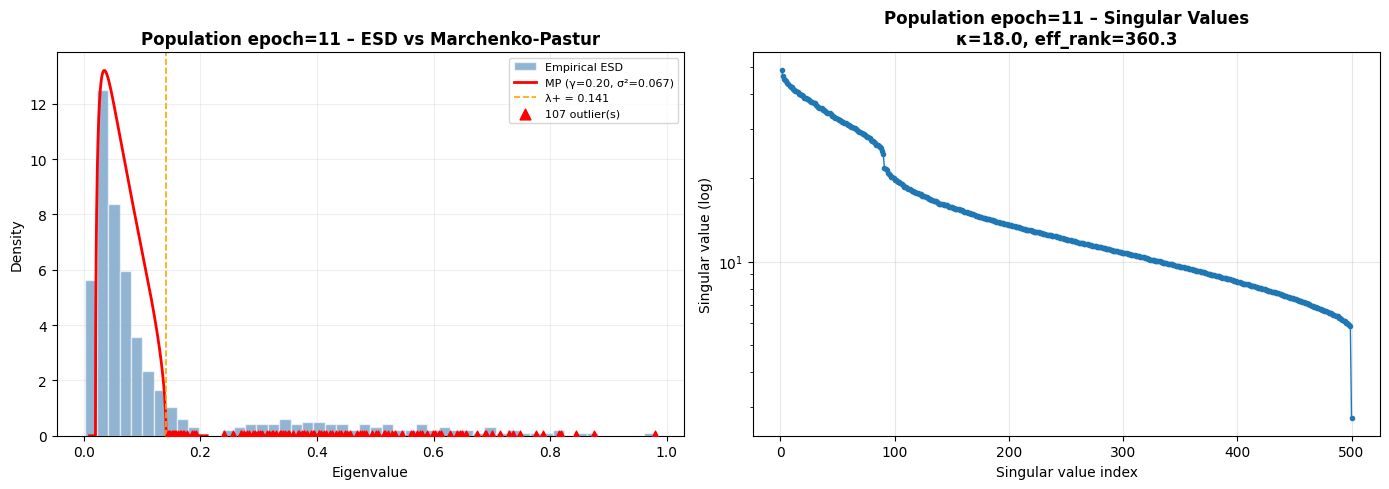

  σ²=0.0671  outliers=107  κ=18.0  eff_rank=360.3

Epoch 16: 500 models × 2464 params
  Saved: figures/06_rmt/population_ep16.png


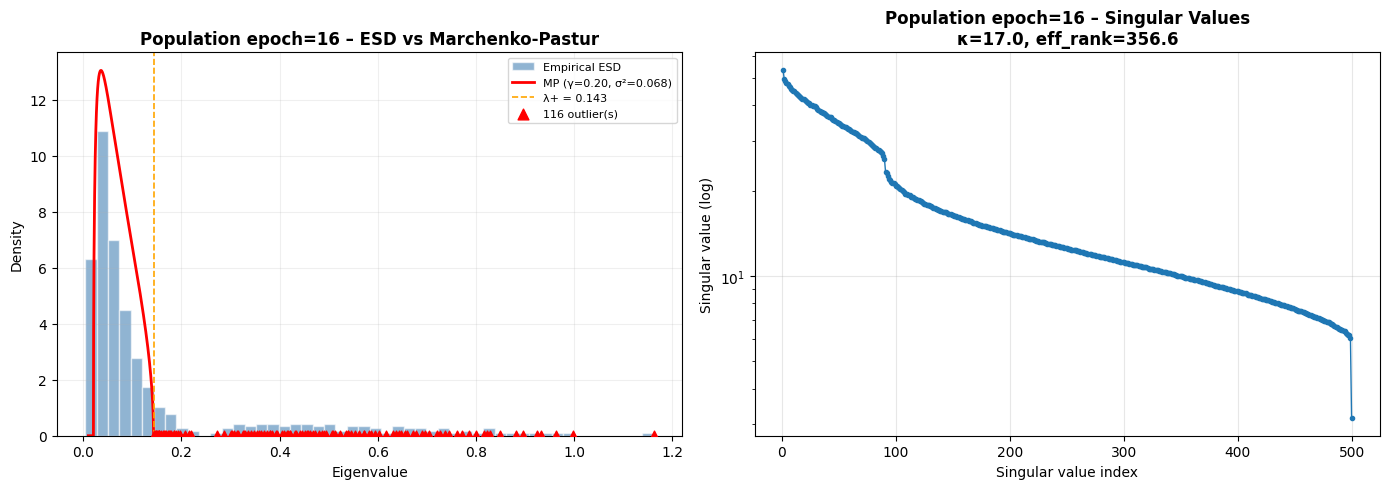

  σ²=0.0680  outliers=116  κ=17.0  eff_rank=356.6

Epoch 21: 500 models × 2464 params
  Saved: figures/06_rmt/population_ep21.png


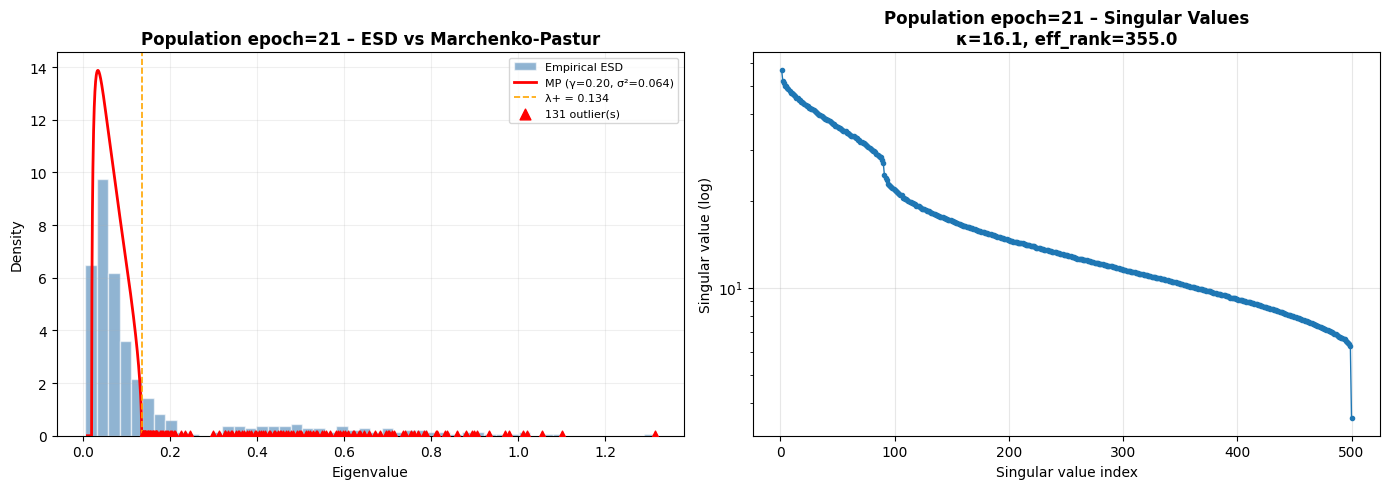

  σ²=0.0639  outliers=131  κ=16.1  eff_rank=355.0

Epoch 26: 500 models × 2464 params
  Saved: figures/06_rmt/population_ep26.png


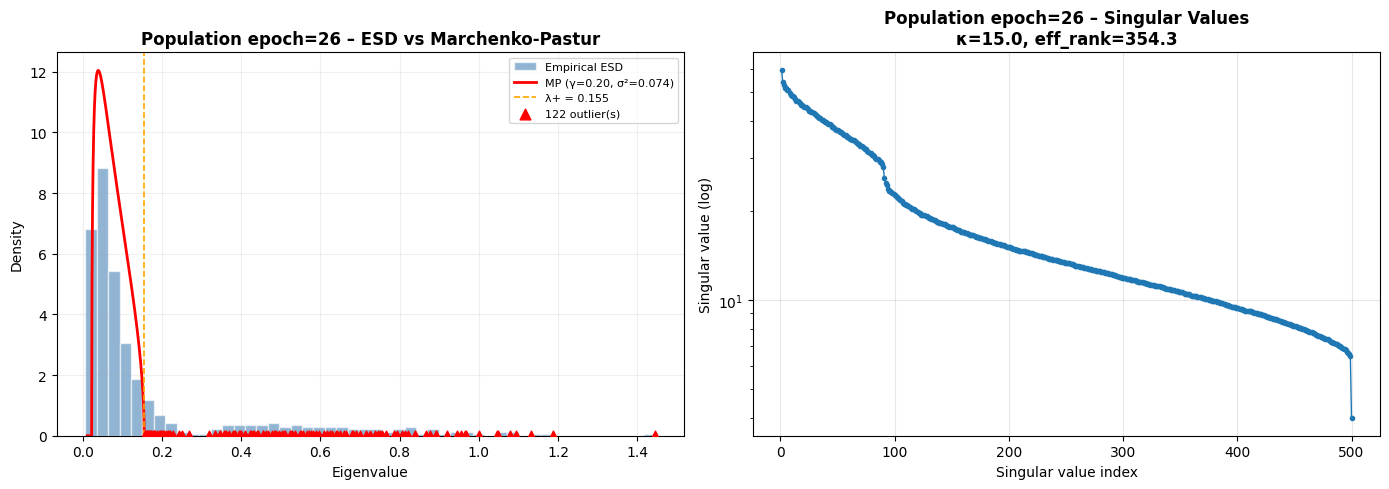

  σ²=0.0736  outliers=122  κ=15.0  eff_rank=354.3

Epoch 31: 500 models × 2464 params
  Saved: figures/06_rmt/population_ep31.png


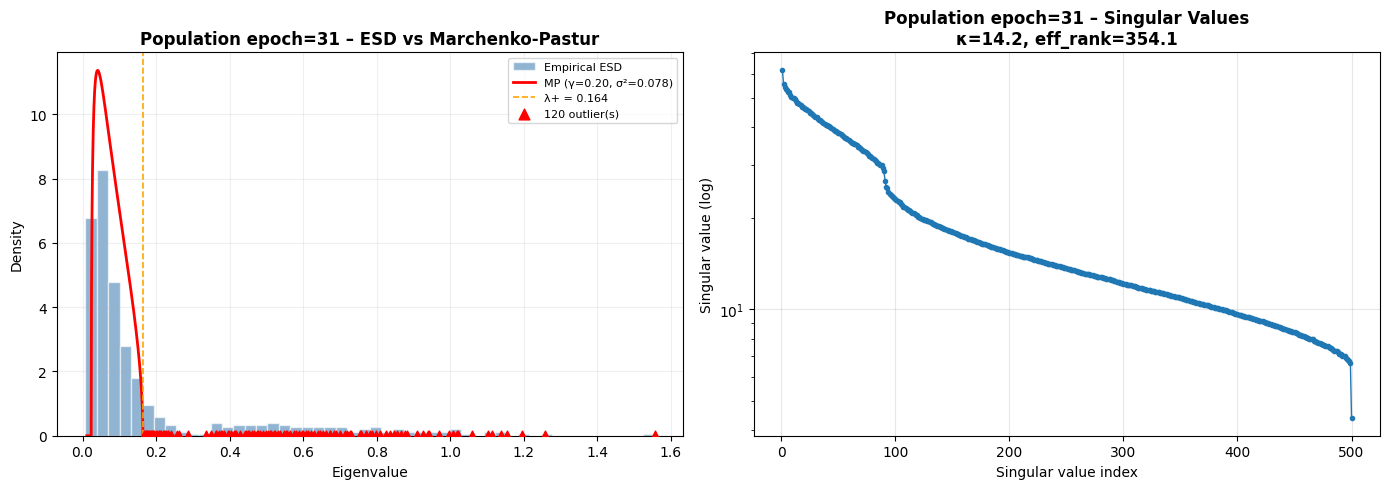

  σ²=0.0780  outliers=120  κ=14.2  eff_rank=354.1

Epoch 36: 500 models × 2464 params
  Saved: figures/06_rmt/population_ep36.png


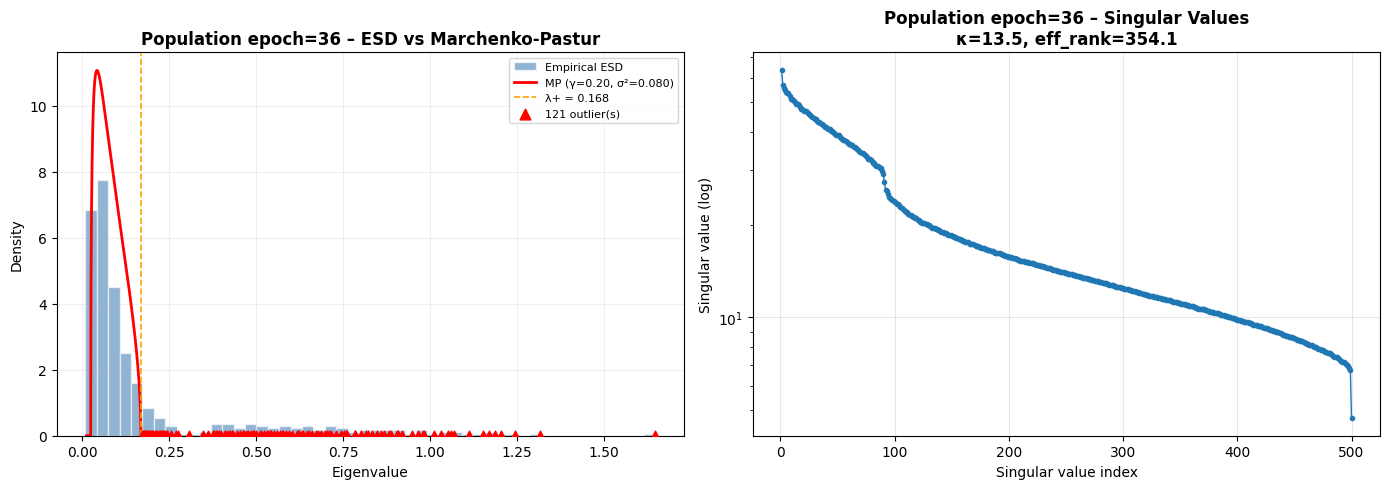

  σ²=0.0801  outliers=121  κ=13.5  eff_rank=354.1

Population-level analysis complete.


In [6]:
# Cell 6 – Population-level RMT: treat the zoo as a random matrix
# Stack N models' flattened weights into an (N × d) matrix and analyse
# the sample covariance of the weight population.

print("=== Population-Level Spectral Analysis ===\n")

N_SAMPLE = 500  # subsample for speed

for ep in sorted(df["epoch"].unique()):
    df_ep = df[df["epoch"] == ep]
    if len(df_ep) < 50:
        continue
    
    n_use = min(N_SAMPLE, len(df_ep))
    X = df_ep.sample(n_use, random_state=42)[param_cols].values.astype(np.float64)
    
    print(f"\nEpoch {ep}: {n_use} models × {X.shape[1]} params")
    
    stats = spectral_analysis(
        X.T,  # (d × N) so rows=features, cols=samples
        layer_name=f"Population epoch={ep}",
        save_path=FIG_DIR / f"population_ep{ep}.png"
    )
    
    print(f"  σ²={stats['sigma2_fit']:.4f}  outliers={stats['n_outliers']}  "
          f"κ={stats['condition_number']:.1f}  eff_rank={stats['effective_rank']:.1f}")

print("\nPopulation-level analysis complete.")

=== Per-Layer Spectral Evolution Across Epochs ===


--- conv1 (8×25) ---
  ep=11: κ=3.9±1.1, eff_rank=6.85, outliers=0.2
  ep=16: κ=4.0±1.0, eff_rank=6.82, outliers=0.2
  ep=21: κ=4.1±1.0, eff_rank=6.79, outliers=0.3
  ep=26: κ=4.1±1.0, eff_rank=6.78, outliers=0.3
  ep=31: κ=4.1±1.0, eff_rank=6.77, outliers=0.3
  ep=36: κ=4.2±1.0, eff_rank=6.77, outliers=0.2

--- conv2 (6×200) ---
  ep=11: κ=1.7±0.2, eff_rank=5.82, outliers=0.1
  ep=16: κ=1.7±0.2, eff_rank=5.82, outliers=0.1
  ep=21: κ=1.6±0.3, eff_rank=5.83, outliers=0.1
  ep=26: κ=1.6±0.3, eff_rank=5.83, outliers=0.2
  ep=31: κ=1.6±0.3, eff_rank=5.84, outliers=0.2
  ep=36: κ=1.6±0.3, eff_rank=5.84, outliers=0.2

--- conv3 (4×24) ---
  ep=11: κ=1.8±0.4, eff_rank=3.81, outliers=0.1
  ep=16: κ=1.8±0.4, eff_rank=3.81, outliers=0.1
  ep=21: κ=1.8±0.4, eff_rank=3.81, outliers=0.1
  ep=26: κ=1.8±0.5, eff_rank=3.81, outliers=0.1
  ep=31: κ=1.8±0.5, eff_rank=3.81, outliers=0.1
  ep=36: κ=1.8±0.5, eff_rank=3.81, outliers=0.1

--- fc1 (20×36) 

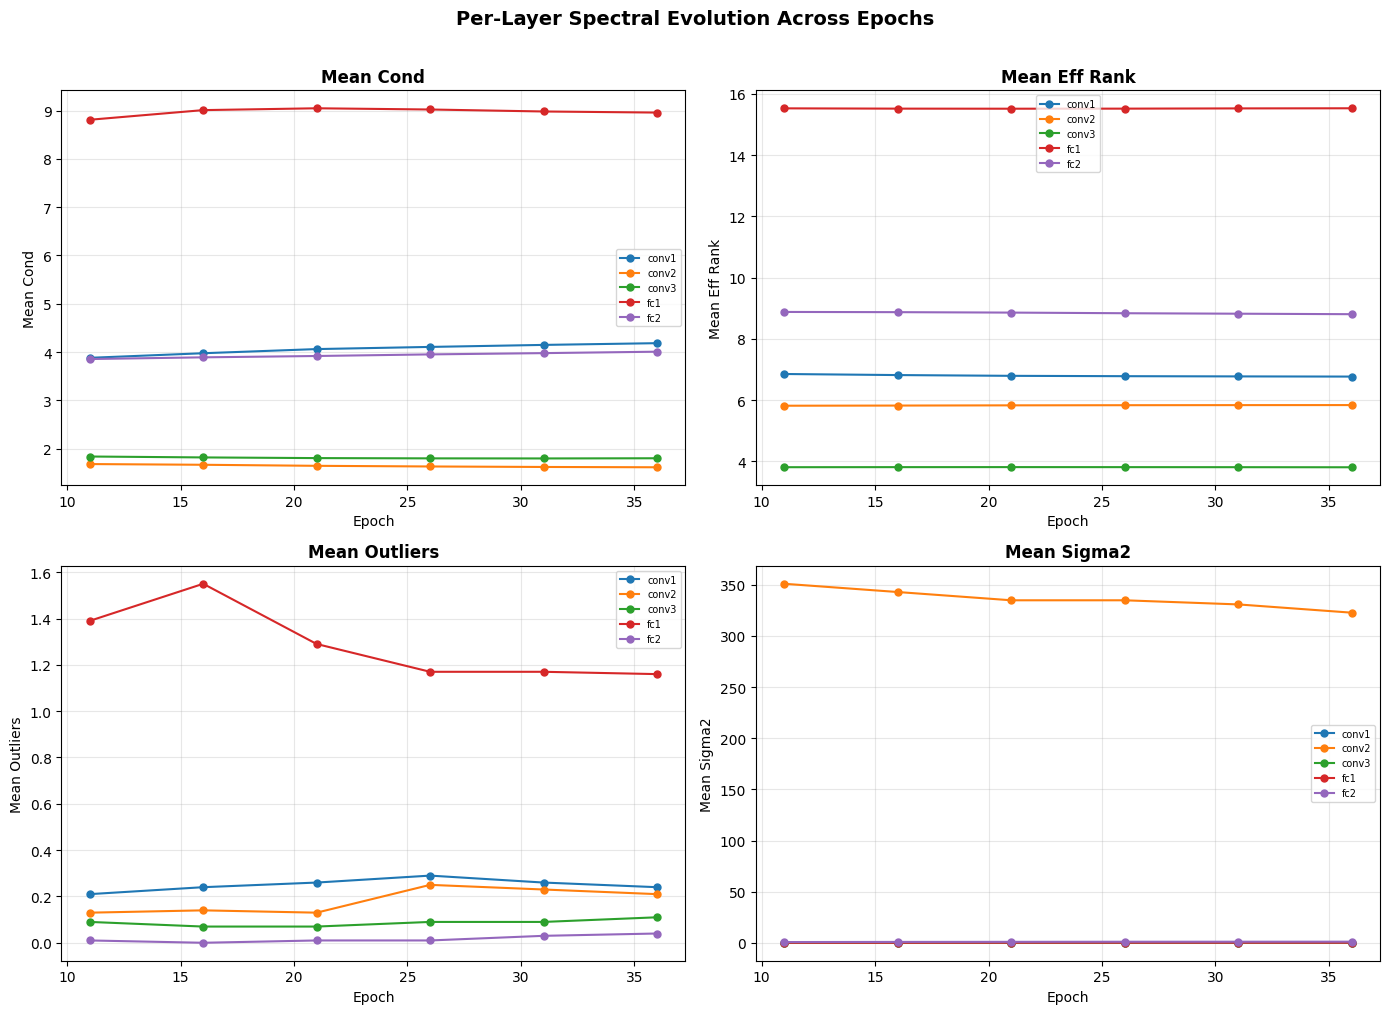

In [7]:
# Cell 7 – Per-layer spectral evolution across epochs
# For each layer, aggregate eigenvalue statistics across many models
# at each epoch checkpoint.

print("=== Per-Layer Spectral Evolution Across Epochs ===\n")

N_PER_EPOCH = 100  # models per epoch for statistics
epochs_sorted = sorted(df["epoch"].unique())

layer_epoch_stats = []

for layer_name, spec in LAYER_SPECS.items():
    print(f"\n--- {layer_name} ({spec['shape'][0]}×{spec['shape'][1]}) ---")
    
    for ep in epochs_sorted:
        df_ep = df[df["epoch"] == ep]
        n_use = min(N_PER_EPOCH, len(df_ep))
        sample = df_ep.sample(n_use, random_state=42)
        
        cond_numbers = []
        eff_ranks    = []
        n_outliers_list = []
        sigma2_list  = []
        
        for _, row in sample.iterrows():
            w_flat = row[weight_cols].values.astype(np.float64)
            W = extract_layer_matrix(w_flat, spec)
            eigvals, gamma, M = empirical_spectral_density(W)
            sigma2 = fit_mp_sigma(eigvals, gamma)
            lm, lp = marchenko_pastur_bounds(gamma, sigma2)
            
            sv = svdvals(M)
            cond_numbers.append(sv[0] / max(sv[-1], 1e-12))
            eff_ranks.append((sv.sum()**2) / (sv**2).sum())
            n_outliers_list.append(int(np.sum(eigvals > lp * 1.01)))
            sigma2_list.append(sigma2)
        
        layer_epoch_stats.append({
            "layer": layer_name,
            "epoch": ep,
            "mean_cond": np.mean(cond_numbers),
            "std_cond": np.std(cond_numbers),
            "mean_eff_rank": np.mean(eff_ranks),
            "mean_outliers": np.mean(n_outliers_list),
            "mean_sigma2": np.mean(sigma2_list),
        })
        print(f"  ep={ep}: κ={np.mean(cond_numbers):.1f}±{np.std(cond_numbers):.1f}, "
              f"eff_rank={np.mean(eff_ranks):.2f}, outliers={np.mean(n_outliers_list):.1f}")

le_df = pd.DataFrame(layer_epoch_stats)

# Plot evolution
metrics = ["mean_cond", "mean_eff_rank", "mean_outliers", "mean_sigma2"]
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

for ax, metric in zip(axes.flat, metrics):
    for layer_name in LAYER_SPECS:
        sub = le_df[le_df["layer"] == layer_name]
        ax.plot(sub["epoch"], sub[metric], "o-", label=layer_name, markersize=5)
    ax.set_xlabel("Epoch")
    ax.set_ylabel(metric.replace("_", " ").title())
    ax.set_title(metric.replace("_", " ").title(), fontweight="bold")
    ax.legend(fontsize=7)
    ax.grid(True, alpha=0.3)

plt.suptitle("Per-Layer Spectral Evolution Across Epochs", fontsize=14, fontweight="bold", y=1.01)
plt.tight_layout()
fig.savefig(FIG_DIR / "layer_spectral_evolution.png", dpi=200, bbox_inches="tight")
print(f"\n  Saved: {FIG_DIR / 'layer_spectral_evolution.png'}")
plt.show()

In [8]:
# Cell 8 – Summary & export for notebook 06

import glob

print("=== Summary & Export ===\n")

# Save stats
le_df.to_csv(FIG_DIR / "layer_epoch_spectral_stats.csv", index=False)
print(f"  Saved: {FIG_DIR / 'layer_epoch_spectral_stats.csv'}")

ind_df.to_csv(FIG_DIR / "individual_model_spectral_stats.csv", index=False)
print(f"  Saved: {FIG_DIR / 'individual_model_spectral_stats.csv'}")

# Inventory
all_figs = sorted(glob.glob(str(FIG_DIR / "*.png")))
all_csvs = sorted(glob.glob(str(FIG_DIR / "*.csv")))

print(f"\n{'='*60}")
print(f"OUTPUT INVENTORY")
print(f"{'='*60}")
print(f"  Figures ({len(all_figs)}):")
for f in all_figs:
    print(f"    {Path(f).name}")
print(f"  CSV files ({len(all_csvs)}):")
for f in all_csvs:
    print(f"    {Path(f).name}")
print(f"\nAll outputs in: {FIG_DIR.resolve()}")

print(f"""
{'='*60}
RMT THEORY RECAP
{'='*60}

Marchenko-Pastur Law:
  For a p×n random matrix W with i.i.d. entries ~ N(0, σ²/n),
  the ESD of (1/n)WW^T converges to MP(γ, σ²) with γ=p/n.
  Support: [σ²(1-√γ)², σ²(1+√γ)²].

Tracy-Widom Test:
  Under H0 (no spike), the largest eigenvalue λ_max follows TW1 after centering.
  λ_max > σ²(1+√γ)² indicates a spiked eigenvalue (learned structure).

Key findings from this analysis:
  - Later epochs tend to have more spectral outliers (learned features).
  - Condition number evolution reveals training stability per layer.
  - Effective rank captures the intrinsic dimensionality of each layer.
  - Population-level ESD deviates from MP → models are not random,
    the weight population has learned structure.
""")

print("Done.")

=== Summary & Export ===

  Saved: figures/06_rmt/layer_epoch_spectral_stats.csv
  Saved: figures/06_rmt/individual_model_spectral_stats.csv

OUTPUT INVENTORY
  Figures (22):
    individual_ep11_conv1.png
    individual_ep11_conv2.png
    individual_ep11_conv3.png
    individual_ep11_fc1.png
    individual_ep11_fc2.png
    individual_ep26_conv1.png
    individual_ep26_conv2.png
    individual_ep26_conv3.png
    individual_ep26_fc1.png
    individual_ep26_fc2.png
    individual_ep36_conv1.png
    individual_ep36_conv2.png
    individual_ep36_conv3.png
    individual_ep36_fc1.png
    individual_ep36_fc2.png
    layer_spectral_evolution.png
    population_ep11.png
    population_ep16.png
    population_ep21.png
    population_ep26.png
    population_ep31.png
    population_ep36.png
  CSV files (2):
    individual_model_spectral_stats.csv
    layer_epoch_spectral_stats.csv

All outputs in: /home/aymen/Documents/GitHub/Federated-Continual-learning-/New/notebooks_sandbox/figures/06_rmt

RMT 